# Wine Dataset EDA

In [1]:
import seaborn as sns
import numpy as np
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import hopsworks
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

In [3]:
#Connection to hopsworks for feature storage
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/204949


Connected. Call `.close()` to terminate connection gracefully.


First, we can visualize and inspect the dataset to check the data types. We can see how the 'type' column presents a categorical value, in contrast with the rest of the features.

In [4]:
#Retrieve the iris dataframe
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
wine_df = pd.read_csv("winequalityN.csv")
wine_df.rename(columns={"fixed acidity": "fixed_acidity", "volatile acidity": "volatile_acidity", "citric acid": "citric_acid", "residual sugar": "residual_sugar",
                        "free sulfur dioxide": "free_sulfur_dioxide", "total sulfur dioxide": "total_sulfur_dioxide"}, inplace = True)

wine_df

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [5]:
#Look at the types of the data
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed_acidity         6487 non-null   float64
 2   volatile_acidity      6489 non-null   float64
 3   citric_acid           6494 non-null   float64
 4   residual_sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Given the non-numerical nature of the 'type' feature, we can convert it to a value format with one-hot encoding, mapping the two categorical types to binary values.

In [6]:
#Convert string values to numbers --> white = 0, red = 1
wine_df['type'] = wine_df['type'].replace({'white': 0, 'red': 1})
wine_df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Another relevant inspection requires considering the presence of null values in the dataset. We can fill the values either with 'Unknown' for categorical variables or coherent numerical values for numerical columns.

In [7]:
print(wine_df.isna().sum())

type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


To fill missing values with relevant information, we can replace them in each numerical column of wine_data with randomly chosen values from the same column, thus preserving the original distribution of values in each column. This can be performing by first collecting the non-missing values of each column, and for each missing input selecting a random element from the same values. The columns are then randomly filled with the extracted numbers.

In [8]:
# Identify categorical and numerical columns
numerical_cols = wine_df.select_dtypes(include=['float64', 'int64']).columns

# For numerical columns, fill missing values with random data from the same distribution
for col in numerical_cols:
    non_missing = wine_df[col].dropna()
    random_fill = np.random.choice(non_missing, size=wine_df[col].isnull().sum())
    wine_df.loc[wine_df[col].isnull(), col] = random_fill

# Verify the changes
missing_values_after = wine_df.isnull().sum()
missing_values_after


type                    0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

To further inspect the available information, aggregated values were visualized.

In [9]:
#Get descriptive statistics
wine_df.describe()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,0.246114,7.217031,0.339645,0.318666,5.445975,0.056036,30.525319,115.744574,0.994697,3.218231,0.531176,10.491801,5.818378
std,0.430779,1.296258,0.164604,0.145286,4.758323,0.035032,17.749400,56.521855,0.002999,0.160758,0.148801,1.192712,0.873255
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,0.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,0.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


The distribution of quality and how some prediction features relate to it can be visualized to examine the nature of the correlation among them.

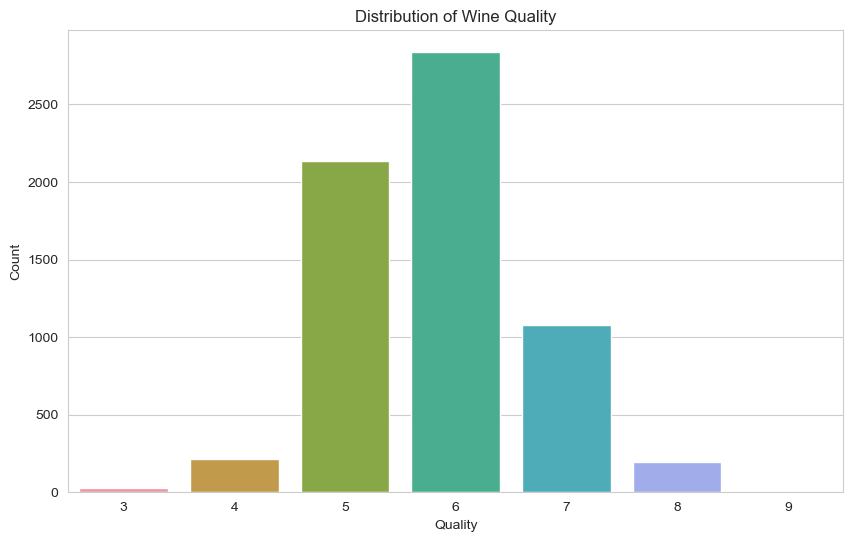

array([3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x='quality', data=wine_df)
plt.title('Distribution of Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

# Check unique values in 'quality'
unique_qualities = wine_df['quality'].unique()
unique_qualities.sort()
unique_qualities


In [25]:
quality_counts = wine_df['quality'].value_counts()
print(quality_counts)
quality_percentage = wine_df['quality'].value_counts(normalize=True) * 100
print(quality_percentage)

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64
6    43.650916
5    32.907496
7    16.607665
4     3.324611
8     2.970602
3     0.461752
9     0.076959
Name: quality, dtype: float64


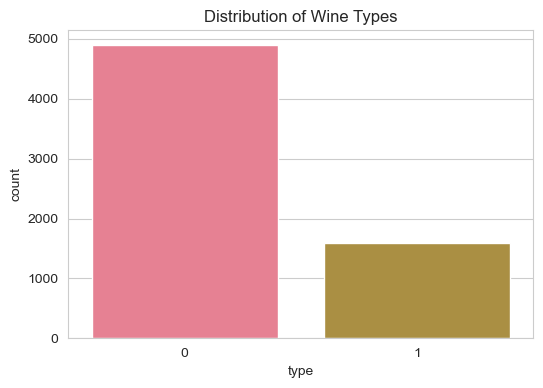

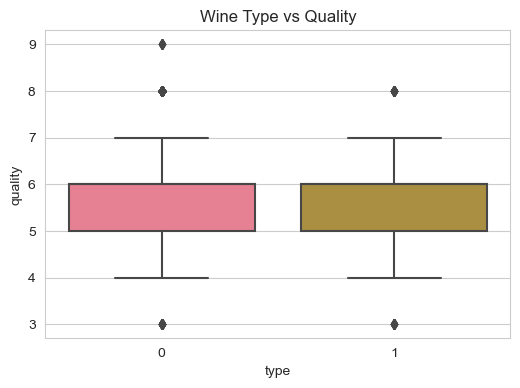

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
type,,,,,,,,,,,,
0,6.856584,0.278226,0.334171,6.395049,0.045776,35.308085,138.360657,0.994027,3.188128,0.489835,10.514267,5.877909
1,8.321138,0.527783,0.271169,2.538806,0.087467,15.874922,46.467792,0.996747,3.310444,0.657811,10.422983,5.636023


In [12]:
# Analysis of the 'type' feature

# Countplot to see the distribution of wine types
plt.figure(figsize=(6, 4))
sns.countplot(x='type', data=wine_df)
plt.title("Distribution of Wine Types")
plt.show()

# Box plot to see the relationship between wine type and quality
plt.figure(figsize=(6, 4))
sns.boxplot(x='type', y='quality', data=wine_df)
plt.title("Wine Type vs Quality")
plt.show()

# Checking average values of features based on wine type
mean_values_by_type = wine_df.groupby('type').mean()
mean_values_by_type


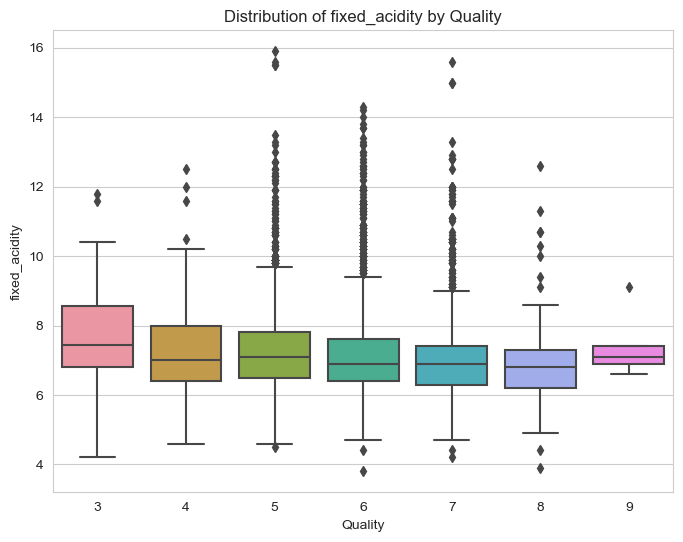

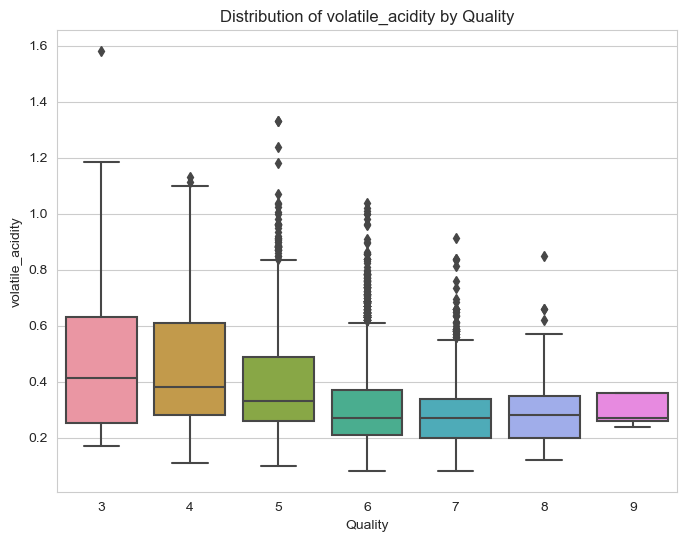

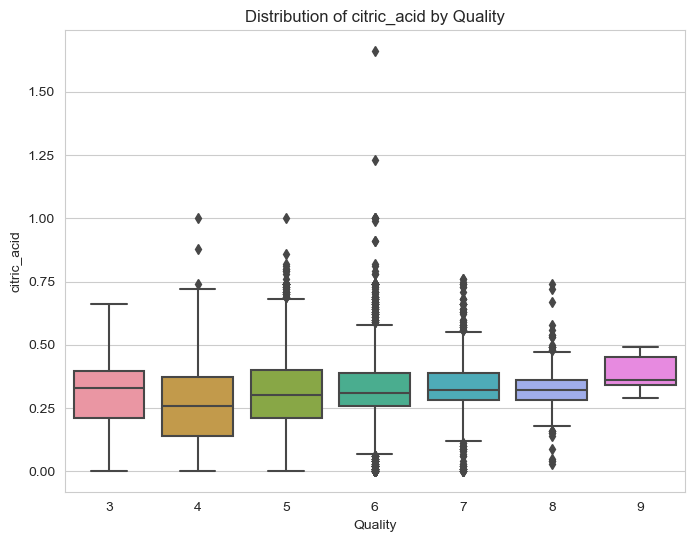

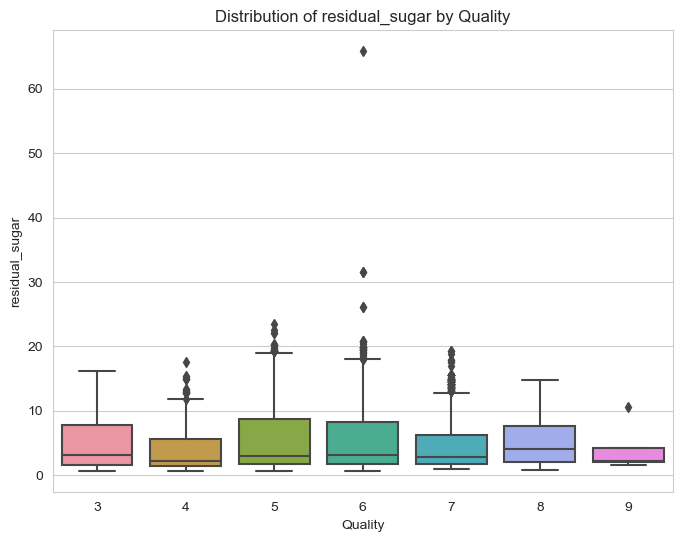

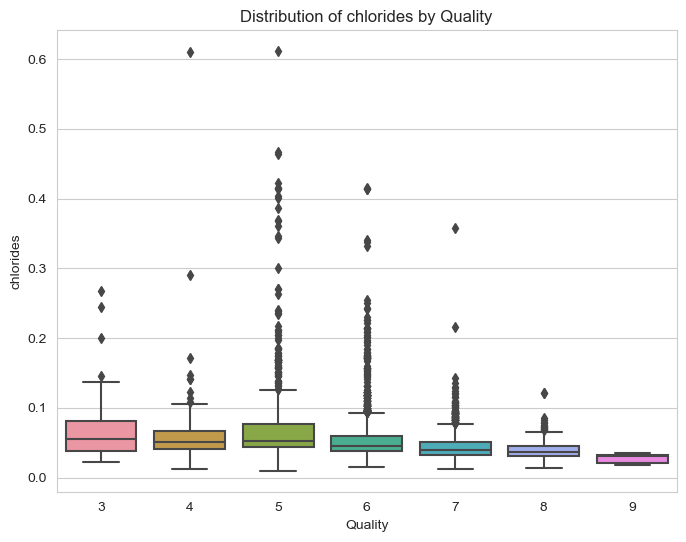

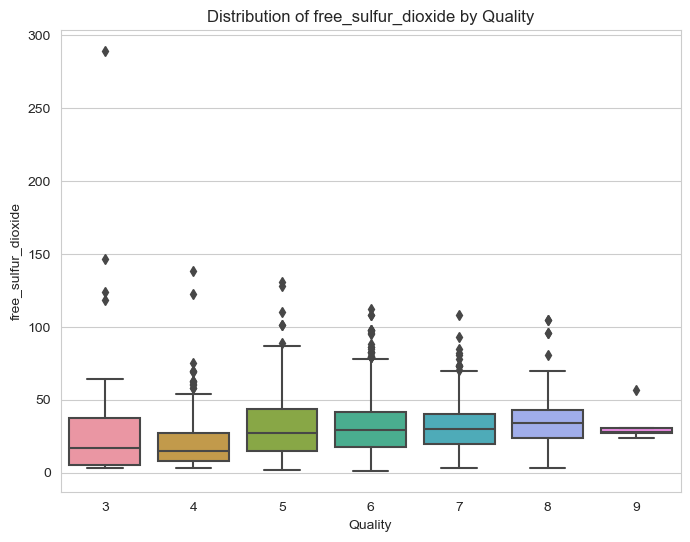

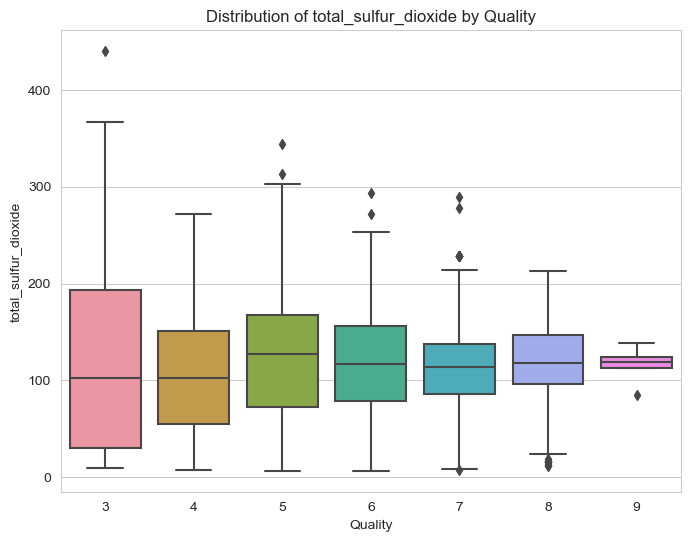

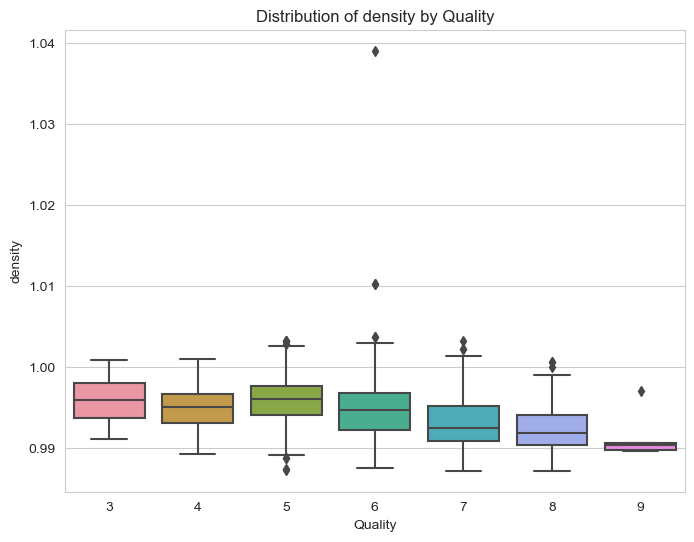

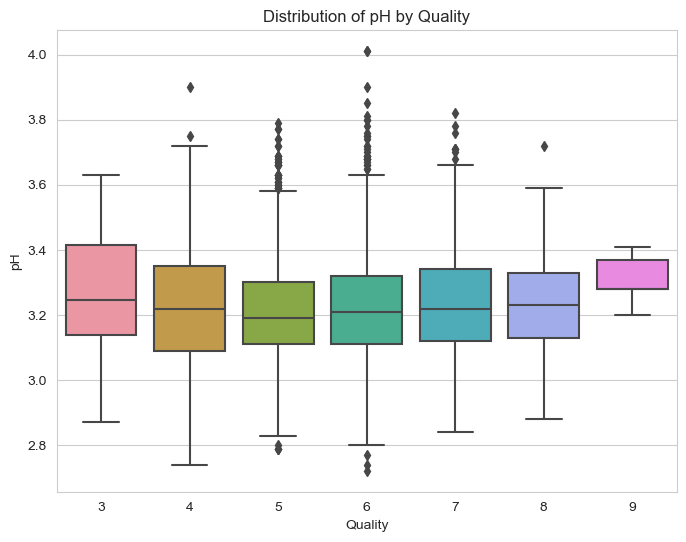

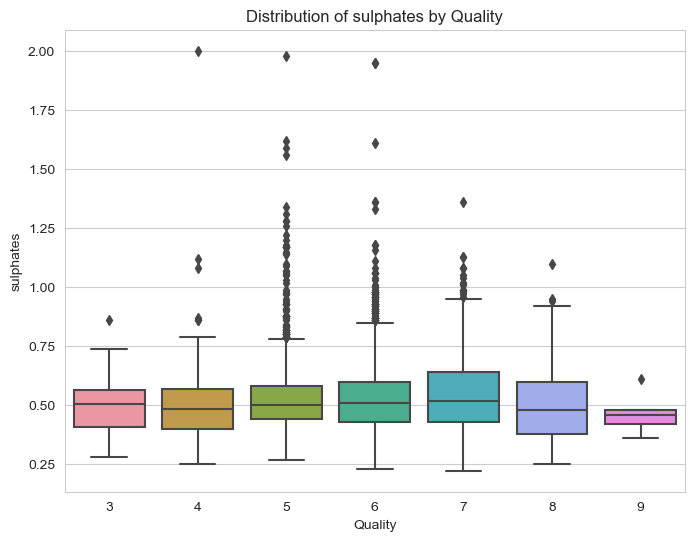

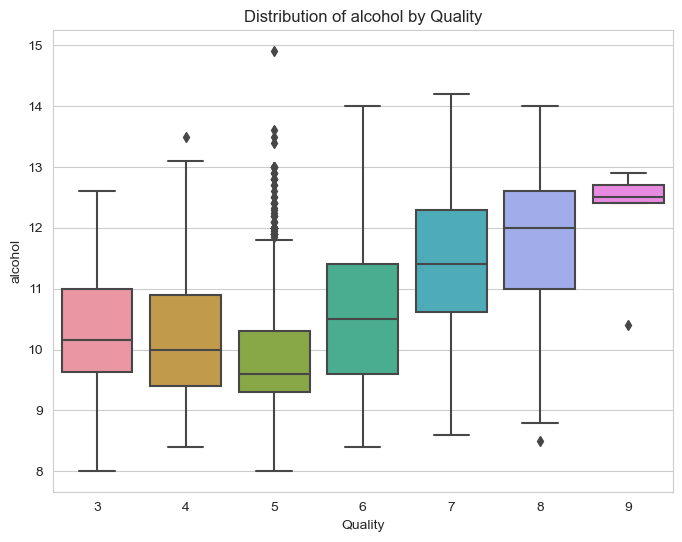

In [13]:
numeric_features = wine_df.iloc[:, 1:12]
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='quality', y=feature, data=wine_df)
    plt.title(f'Distribution of {feature} by Quality')
    plt.xlabel('Quality')
    plt.ylabel(feature)
    plt.show()

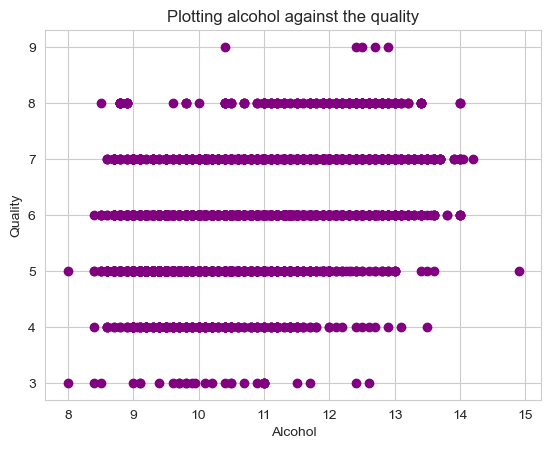

In [14]:
#Plot a scatter plot of alcohol against its quality
plt.scatter(wine_df['alcohol'],wine_df['quality'], color='purple')
plt.xlabel('Alcohol')
plt.ylabel('Quality')
plt.title('Plotting alcohol against the quality')
plt.grid(True)
plt.show()

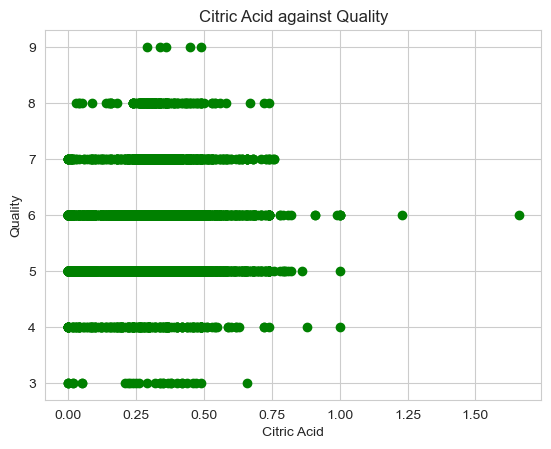

In [15]:
#Plotting volatile acidity against quality
import matplotlib.pyplot as plt
plt.scatter(wine_df['citric_acid'],wine_df['quality'], color='green')
plt.xlabel('Citric Acid')
plt.ylabel('Quality')
plt.title('Citric Acid against Quality')
plt.grid(True)
plt.show()

From the previous plots we can see that there is no linear relationship between the target and the features. In addition, we can score the features to examine which ones show the most and least correlation with the target variable.

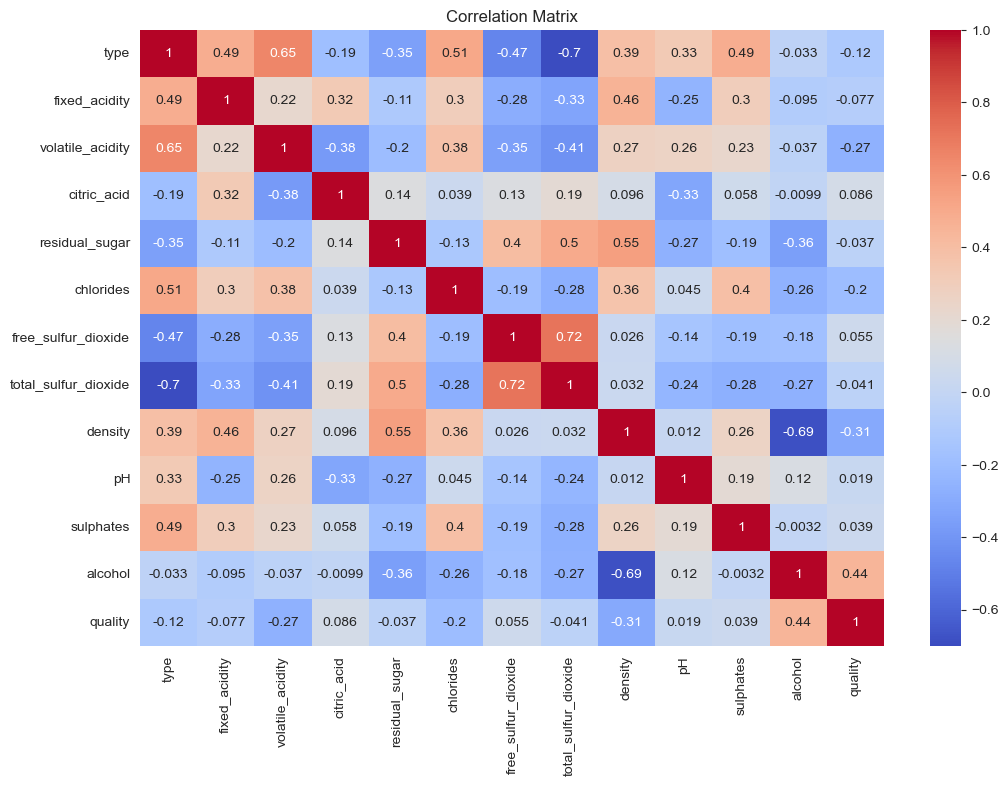

In [16]:
correlation_matrix = wine_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [17]:
import pandas as pd

# Assuming 'wine_data' is your DataFrame
outlier_counts = {}

for column in wine_df.columns:
    if wine_df[column].dtype in ['float64', 'int64']:
        Q1 = wine_df[column].quantile(0.25)
        Q3 = wine_df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = wine_df[(wine_df[column] < lower_bound) | (wine_df[column] > upper_bound)]
        outlier_counts[column] = outliers.shape[0]
outlier_counts

{'type': 1599,
 'fixed_acidity': 357,
 'volatile_acidity': 376,
 'citric_acid': 509,
 'residual_sugar': 118,
 'chlorides': 286,
 'free_sulfur_dioxide': 62,
 'total_sulfur_dioxide': 10,
 'density': 3,
 'pH': 73,
 'sulphates': 191,
 'alcohol': 3,
 'quality': 228}

In [18]:
wine_df = wine_df.drop(columns=['citric_acid', 'fixed_acidity', 'residual_sugar'])
wine_df

,type,volatile_acidity,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,0,0.270,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,0,0.300,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,0,0.280,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,0,0.230,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,0,0.230,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...
6492,1,0.600,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,1,0.550,0.062,39.0,51.0,0.99512,3.52,0.39,11.2,6
6494,1,0.510,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,1,0.645,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
sns.pairplot(data=wine_df,hue='quality')

We can further inspect the dataset to find out the frequency of each unique value in the 'quality' column. This way, we can find out how balanced the class assignment in the dataset are. We'll calculate the percentage distribution for clearer understanding.

Based on these results, we can see that possible skews might have to be re-balanced in later classification approaches.

In [23]:
#Now we write our historical feature values and labels to a feature group (backfilling)
#Insert the dataframe into the feature store
wine_fg = fs.get_or_create_feature_group(
    name="wine_reduced_new",
    version=1,
    primary_key=["type", "volatile_acidity", "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "pH", "sulphates", "alcohol"],
    description="Wine dataset reduced and preprocessed")
wine_fg.insert(wine_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/204949/fs/204868/fg/220525


Uploading Dataframe: 0.00% |          | Rows 0/6497 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: wine_reduced_new_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/204949/jobs/named/wine_reduced_new_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x2470adee040>, None)

In [21]:
#The code below will prevent wine data from being written to 
#your feature group if you write values outside the expected ranges.
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

def expect(suite, column, min_val, max_val):
    suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={
            "column":column, 
            "min_value":min_val,
            "max_value":max_val,
        }
    )
)

In [22]:
suite = ExpectationSuite(expectation_suite_name="wine_values")

expect(suite, "volatile_acidity", 0.08, 1.58)
expect(suite, "chlorides", 0.009, 0.611)
expect(suite, "free_sulfur_dioxide", 1, 289)
expect(suite, "total_sulfur_dioxide", 6, 440)
expect(suite, "density", 0.98711, 1.03898)
expect(suite, "ph", 2.72, 4.01)
expect(suite, "sulphates", 0.22, 2)
expect(suite, "alcohol", 8, 14.9)


wine_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT") 

Attached expectation suite to Feature Group, edit it at https://c.app.hopsworks.ai:443/p/204949/fs/204868/fg/220524


In [24]:
wine_df.shape

(6497, 10)